# Food recommendation System using Collaborative Filtering

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
menu = pd.read_csv('Test_menu.csv')
users = pd.read_csv('Test_users.csv')
ratings = pd.read_csv('Test_ratings.csv')

In [ ]:
users.head()

,user_id,UserName
0,1,JohnDoe
1,2,JaneSmith
2,3,RobertJohnson
3,4,EmilyJones
4,5,MichaelBrown


In [ ]:
menu.head()

,ItemID,Category,ItemName,Description,Price,ImageURL
0,1,Appetizers,Caprese Salad,"Fresh tomatoes, mozzarella, basil, olive oil, ...",749.25,caprese_salad_image.jpg
1,2,Appetizers,Bruschetta,"Toasted bread topped with tomatoes, garlic, ba...",636.75,bruschetta_image.jpg
2,3,Appetizers,Chicken Wings,Crispy fried chicken wings tossed in buffalo s...,824.25,chicken_wings_image.jpg
3,4,Appetizers,Stuffed Mushrooms,Mushroom caps stuffed with seasoned breadcrumb...,711.75,stuffed_mushrooms_image.jpg
4,5,Appetizers,Shrimp Cocktail,Chilled shrimp served with cocktail sauce.,899.25,shrimp_cocktail_image.jpg


In [ ]:
ratings.head()

,user_id,ItemID,rating
0,1,10,4
1,2,25,3
2,3,5,2
3,4,30,5
4,5,15,4


# Exploratory Data Analysis

In [ ]:
print(menu.shape)
print(users.shape)
print(ratings.shape)

(180, 6)
(500, 2)
(7164, 3)


In [ ]:
menu.duplicated().sum()

0

In [ ]:
users.duplicated().sum()

0

In [ ]:
ratings.duplicated().sum()

1534

In [ ]:
menu.describe()

,ItemID,Price
count,180.000000,180.000000
mean,90.500000,790.416667
std,52.105662,402.353794
min,1.000000,149.250000
25%,45.750000,561.750000
50%,90.500000,718.000000
75%,135.250000,899.250000
max,180.000000,2624.250000


In [ ]:
users.describe()

,user_id
count,500.000000
mean,250.500000
std,144.481833
min,1.000000
25%,125.750000
50%,250.500000
75%,375.250000
max,500.000000


In [ ]:
num_cols = ratings.describe()

user_id
Skew : -0.35


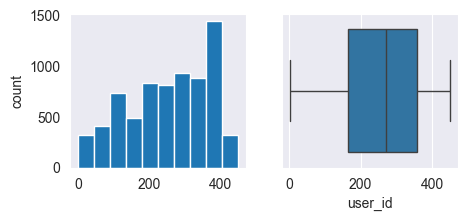

ItemID
Skew : 0.09


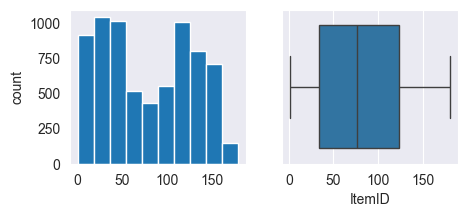

rating
Skew : 0.31


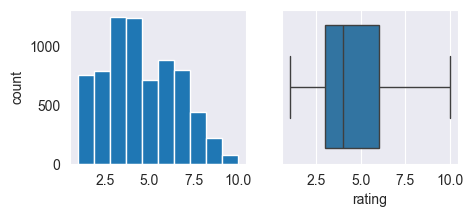

In [ ]:
for col in num_cols:
    print(col)
    print('Skew :', round(ratings[col].skew(), 2))
    plt.figure(figsize = (5, 2))
    plt.subplot(1, 2, 1)
    ratings[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=ratings[col])
    plt.show()

<Figure size 1500x1500 with 0 Axes>

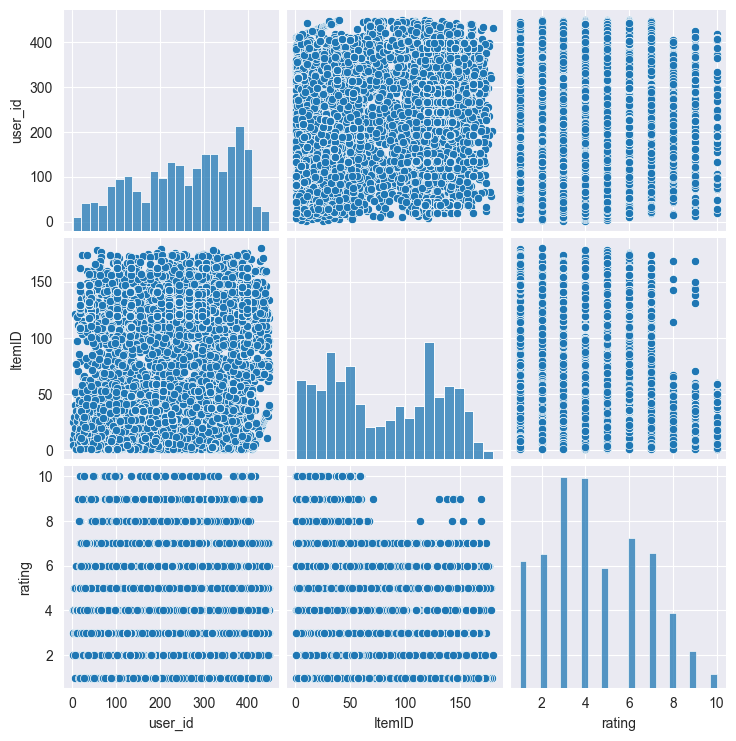

In [ ]:
plt.figure(figsize=(15,15))
sns.pairplot(data=ratings)
plt.show()

<Axes: xlabel='ItemID', ylabel='count'>

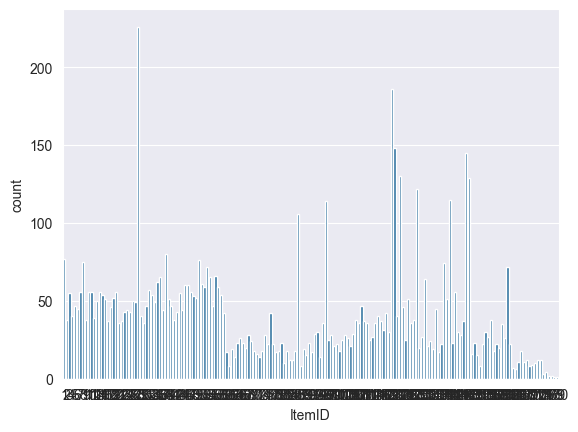

In [ ]:
sns.countplot(x='ItemID', data=ratings)

<Axes: xlabel='ItemID', ylabel='rating'>

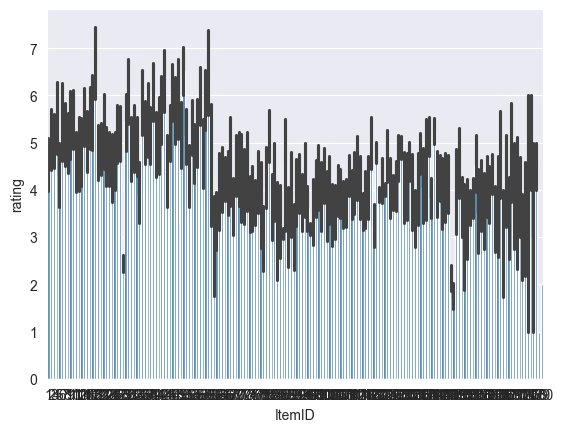

In [ ]:
sns.barplot (x ='ItemID' , y='rating', data = ratings)

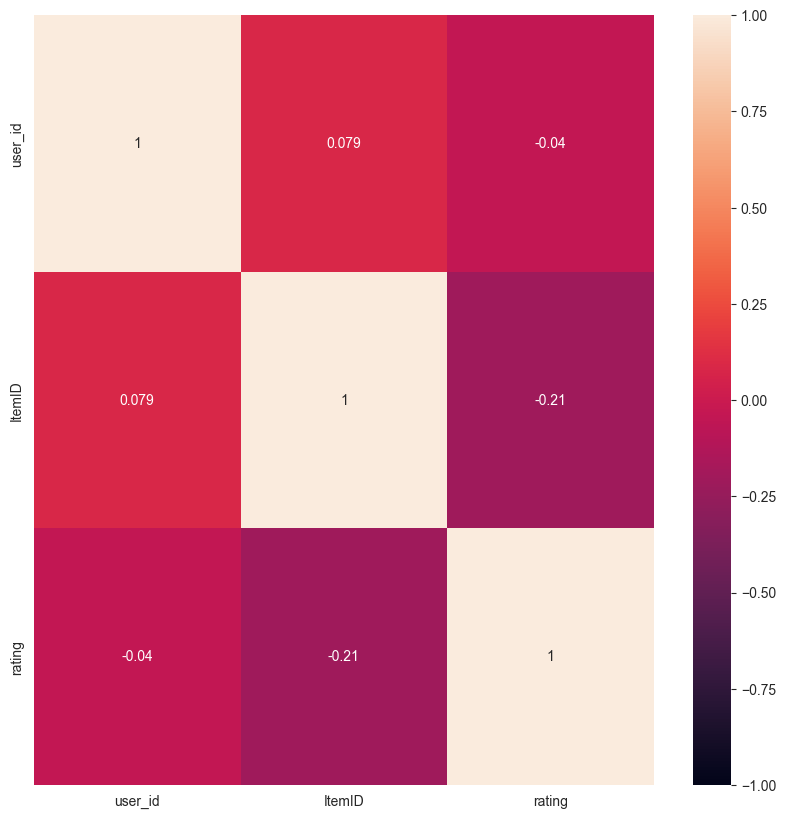

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(ratings.corr(), annot = True, vmin = -1, vmax = 1)
plt.show()

# Popularity Based Recommender System

In [ ]:
#based of items which got more than 50 ratings
ratings_with_itemname = ratings.merge(menu, on = 'ItemID')
ratings_with_itemname

,user_id,ItemID,rating,Category,ItemName,Description,Price,ImageURL
0,1,10,4,Appetizers,Spinach Artichoke Dip,"Creamy dip made with spinach, artichokes, and ...",599.25,spinach_artichoke_dip_image.jpg
1,2,25,3,Lunch,Mediterranean Wrap,"Grilled vegetables, hummus, feta cheese, lettu...",636.75,lunch_image_5.jpg
2,3,5,2,Appetizers,Shrimp Cocktail,Chilled shrimp served with cocktail sauce.,899.25,shrimp_cocktail_image.jpg
3,4,30,5,Lunch,Caesar Wrap,"Grilled chicken, romaine lettuce, parmesan che...",749.25,lunch_image_10.jpg
4,5,15,4,Breakfast,Belgian Waffles,Crispy waffles served with fresh berries and w...,749.25,breakfast_image_5.jpg
...,...,...,...,...,...,...,...,...
7159,162,35,9,Dinner,Surf and Turf,Grilled steak and lobster tail served with a s...,2624.25,dinner_image_5.jpg
7160,402,23,6,Lunch,Margherita Pizza,"Thin crust pizza with tomatoes, fresh mozzarel...",974.25,lunch_image_3.jpg
7161,81,1,3,Appetizers,Caprese Salad,"Fresh tomatoes, mozzarella, basil, olive oil, ...",749.25,caprese_salad_image.jpg
7162,367,54,2,Beverages,Soft Drinks,Assorted soft drinks.,186.75,beverage_image_4.jpg


In [ ]:
ratings_with_itemname.columns

Index(['user_id', 'ItemID', 'rating', 'Category', 'ItemName', 'Description',
       'Price', 'ImageURL'],
      dtype='object')

In [ ]:
#if we have two items with similar names but different ItemID
num_rating_df = ratings_with_itemname.groupby('ItemName').count()['rating'].reset_index()
num_rating_df.rename(columns={'rating':'num_ratings'},inplace = True)

#size() counts the number of times each unique combination of "ItemName" and "Description" appears in the DataFrame.
#.to_frame() method creates a new DataFrame
# num_rating_df = ratings_with_itemname.groupby(['ItemName', 'Description']).size().to_frame(name='num_ratings').reset_index()
num_rating_df



,ItemName,num_ratings
0,Apple Cinnamon Crisp,38
1,Artichoke Dip,18
2,Avocado Benedict,16
3,Avocado Toast,23
4,BBQ Pulled Pork Sandwich,106
...,...,...
175,Veggie Burger,12
176,Watermelon Mint Lemonade,26
177,Western Omelette,18
178,White Chocolate Raspberry Mousse,18


In [ ]:
avg_rating_df = ratings_with_itemname.groupby('ItemName').mean(numeric_only=True)['rating'].reset_index() #ignoring non-numeric values.
avg_rating_df.rename(columns={'rating':'avg_ratings'},inplace = True)

# avg_rating_df = ratings_with_itemname.groupby(['ItemName', 'Description']).size().to_frame(name='avg_ratings').reset_index()
avg_rating_df


,ItemName,avg_ratings
0,Apple Cinnamon Crisp,4.526316
1,Artichoke Dip,4.444444
2,Avocado Benedict,4.187500
3,Avocado Toast,4.217391
4,BBQ Pulled Pork Sandwich,3.066038
...,...,...
175,Veggie Burger,3.083333
176,Watermelon Mint Lemonade,3.923077
177,Western Omelette,4.388889
178,White Chocolate Raspberry Mousse,3.500000


In [ ]:
popular_df = num_rating_df.merge(avg_rating_df, on ='ItemName')
popular_df

,ItemName,num_ratings,avg_ratings
0,Apple Cinnamon Crisp,38,4.526316
1,Artichoke Dip,18,4.444444
2,Avocado Benedict,16,4.187500
3,Avocado Toast,23,4.217391
4,BBQ Pulled Pork Sandwich,106,3.066038
...,...,...,...
175,Veggie Burger,12,3.083333
176,Watermelon Mint Lemonade,26,3.923077
177,Western Omelette,18,4.388889
178,White Chocolate Raspberry Mousse,18,3.500000


In [ ]:
#top 20 popular items sorted in descending order with more than 50 user ratings(num_ratings)
popular_df = popular_df[popular_df['num_ratings']>=50].sort_values('avg_ratings',ascending = False).head(20)
popular_df

,ItemName,num_ratings,avg_ratings
108,Molten Chocolate Soufflé,76,6.513158
159,Tiramisu,55,6.327273
149,Stuffed Bell Peppers,51,6.098039
89,Key Lime Pie,60,6.066667
70,Fresh Fruit Juice,66,5.984848
9,Banana Split,53,5.924528
17,Bottled Water,54,5.870370
153,Surf and Turf,62,5.838710
131,Red Velvet Cake,56,5.714286
172,Vegetarian Omelette,56,5.535714


In [ ]:
popular_df = popular_df.merge(menu, on='ItemName').drop_duplicates('ItemName')[['ItemName', 'Category', 'Description', 'Price', 'ImageURL', 'num_ratings', 'avg_ratings']]
popular_df


,ItemName,Description,Price,ImageURL,num_ratings,avg_ratings
0,Molten Chocolate Soufflé,Decadent chocolate soufflé with a gooey molten...,861.75,dessert_image_10.jpg,76,6.513158
1,Tiramisu,Classic Italian dessert made with layers of co...,599.25,dessert_image_3.jpg,55,6.327273
2,Stuffed Bell Peppers,Bell peppers stuffed with seasoned ground beef...,1461.75,dinner_image_9.jpg,51,6.098039
3,Key Lime Pie,Tangy key lime filling in a graham cracker cru...,561.75,dessert_image_6.jpg,60,6.066667
4,Fresh Fruit Juice,Variety of freshly squeezed fruit juices.,374.25,beverage_image_6.jpg,66,5.984848
5,Banana Split,"Scoops of vanilla, chocolate, and strawberry i...",786.75,dessert_image_8.jpg,53,5.924528
6,Bottled Water,Bottled still or sparkling water.,149.25,beverage_image_8.jpg,54,5.870370
7,Surf and Turf,Grilled steak and lobster tail served with a s...,2624.25,dinner_image_5.jpg,62,5.838710
8,Red Velvet Cake,Moist red velvet cake layers with cream cheese...,749.25,dessert_image_7.jpg,56,5.714286
9,Vegetarian Omelette,Omelette filled with sautéed vegetables and ch...,711.75,breakfast_image_4.jpg,56,5.535714


In [ ]:
data_preprocessed = ratings_with_itemname.isnull()

# Collaborative Filtering Based Recommender System

In [ ]:
#items rated by users who have given rating more than 50 times
x = ratings_with_itemname.groupby('user_id').count()['rating'] > 50
educated_users = x[x].index
educated_users

Index([ 38,  44, 102, 132, 135, 194, 222, 243, 244, 283, 287, 297, 306, 326,
       364, 376, 388, 391, 392, 399],
      dtype='int64', name='user_id')

In [ ]:
#rating based on users
filtered_rating = ratings_with_itemname[ratings_with_itemname['user_id'].isin(educated_users)]
filtered_rating

,user_id,ItemID,rating,Category,ItemName,Description,Price,ImageURL
37,38,53,2,Beverages,Hot Tea,Assorted varieties of hot tea.,224.25,beverage_image_3.jpg
43,44,39,4,Dinner,Stuffed Bell Peppers,Bell peppers stuffed with seasoned ground beef...,1461.75,dinner_image_9.jpg
101,102,55,5,Beverages,Iced Tea,Refreshing iced tea.,261.75,beverage_image_5.jpg
131,132,28,1,Lunch,Vegetable Minestrone Soup,"Hearty soup with assorted vegetables, beans, a...",486.75,lunch_image_8.jpg
134,135,23,4,Lunch,Margherita Pizza,"Thin crust pizza with tomatoes, fresh mozzarel...",974.25,lunch_image_3.jpg
...,...,...,...,...,...,...,...,...
7058,297,20,6,Breakfast,Breakfast Sandwich,"English muffin with eggs, bacon, cheese, and t...",636.75,breakfast_image_10.jpg
7078,132,1,2,Appetizers,Caprese Salad,"Fresh tomatoes, mozzarella, basil, olive oil, ...",749.25,caprese_salad_image.jpg
7102,132,1,2,Appetizers,Caprese Salad,"Fresh tomatoes, mozzarella, basil, olive oil, ...",749.25,caprese_salad_image.jpg
7126,132,1,2,Appetizers,Caprese Salad,"Fresh tomatoes, mozzarella, basil, olive oil, ...",749.25,caprese_salad_image.jpg


In [ ]:
#rating based on Items
y = filtered_rating.groupby('ItemName').count()['rating'] >=10
famous_items = y[y].index
famous_items

Index(['Apple Cinnamon Crisp', 'BBQ Pulled Pork Sandwich',
       'Bacon-Wrapped Jalapeños', 'Black Bean and Corn Salad',
       'Blueberry Lavender Lemonade', 'Caprese Salad', 'Chicken Pesto Pasta',
       'Coq au Vin', 'Eggplant and Chickpea Curry', 'Espresso Martini',
       'Ginger Soy Glazed Chicken', 'Honey Sriracha Chicken Bites',
       'Lamb Kebabs', 'Lemon Herb Grilled Salmon', 'Mango Chicken Quesadillas',
       'Mango Salsa with Avocado', 'Peach Melba', 'Pineapple Ginger Smoothie',
       'Pulled Pork Sliders', 'Raspberry Almond Tart',
       'Spinach and Feta Stuffed Chicken', 'Strawberry Basil Sparkler',
       'Teriyaki Glazed Edamame', 'Thai Peanut Noodles', 'Truffle Fries',
       'Vegetable Minestrone Soup'],
      dtype='object', name='ItemName')

In [ ]:
#filtered_rating in famous_items
final_ratings = filtered_rating[filtered_rating['ItemName'].isin(famous_items)]
final_ratings.drop_duplicates()

,user_id,ItemID,rating,Category,ItemName,Description,Price,ImageURL
131,132,28,1,Lunch,Vegetable Minestrone Soup,"Hearty soup with assorted vegetables, beans, a...",486.75,lunch_image_8.jpg
1250,392,28,9,Lunch,Vegetable Minestrone Soup,"Hearty soup with assorted vegetables, beans, a...",486.75,lunch_image_8.jpg
1553,102,28,6,Lunch,Vegetable Minestrone Soup,"Hearty soup with assorted vegetables, beans, a...",486.75,lunch_image_8.jpg
1806,399,148,6,Dinner,Eggplant and Chickpea Curry,Eggplant and chickpeas cooked in a flavorful c...,1511.75,dinner_image_28.jpg
1852,376,123,4,Appetizers,Teriyaki Glazed Edamame,Steamed edamame pods tossed in a sweet and sav...,749.25,teriyaki_edamame_image.jpg
...,...,...,...,...,...,...,...,...
6057,287,139,5,Lunch,Spinach and Feta Stuffed Chicken,"Chicken breast stuffed with spinach and feta, ...",1011.75,lunch_image_29.jpg
6058,135,110,4,Desserts,Peach Melba,Vanilla ice cream topped with peaches and rasp...,699.25,dessert_image_20.jpg
6873,44,1,3,Appetizers,Caprese Salad,"Fresh tomatoes, mozzarella, basil, olive oil, ...",749.25,caprese_salad_image.jpg
6958,132,1,2,Appetizers,Caprese Salad,"Fresh tomatoes, mozzarella, basil, olive oil, ...",749.25,caprese_salad_image.jpg


In [ ]:
pt = final_ratings.pivot_table(index='ItemName', columns='user_id', values='rating')
pt

user_id,38,44,102,132,135,194,222,243,244,283,287,297,306,326,364,376,388,391,392,399
ItemName,,,,,,,,,,,,,,,,,,,,
Apple Cinnamon Crisp,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,6.076923,NaN,NaN,7.000000
BBQ Pulled Pork Sandwich,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,3.000000,3.0,NaN,NaN
Bacon-Wrapped Jalapeños,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.000000
Black Bean and Corn Salad,6.769231,NaN,6.00,NaN,NaN,NaN,7.0,NaN,3.0,NaN,4.000000,6.000000,NaN,NaN,NaN,NaN,NaN,6.0,NaN,5.000000
Blueberry Lavender Lemonade,4.142857,3.666667,3.16,5.705882,7.00,6.958333,5.0,NaN,7.0,NaN,4.000000,4.896552,7.0,NaN,NaN,NaN,5.200000,NaN,NaN,5.500000
Caprese Salad,NaN,3.000000,2.00,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
Chicken Pesto Pasta,4.000000,3.000000,NaN,NaN,NaN,6.000000,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Coq au Vin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
Eggplant and Chickpea Curry,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,6.000000


In [ ]:
pt.fillna(0,inplace = True)
pt #items as rows and users as columns 

user_id,38,44,102,132,135,194,222,243,244,283,287,297,306,326,364,376,388,391,392,399
ItemName,,,,,,,,,,,,,,,,,,,,
Apple Cinnamon Crisp,3.000000,0.000000,0.00,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,3.000000,0.000000,0.0,0.0,0.0,0.0,6.076923,0.0,0.0,7.000000
BBQ Pulled Pork Sandwich,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,4.000000,0.0,0.0,0.0,0.0,3.000000,3.0,0.0,0.000000
Bacon-Wrapped Jalapeños,0.000000,6.000000,0.00,0.000000,0.00,0.000000,0.0,0.0,3.0,0.0,0.000000,0.000000,0.0,0.0,0.0,4.0,0.000000,0.0,0.0,4.000000
Black Bean and Corn Salad,6.769231,0.000000,6.00,0.000000,0.00,0.000000,7.0,0.0,3.0,0.0,4.000000,6.000000,0.0,0.0,0.0,0.0,0.000000,6.0,0.0,5.000000
Blueberry Lavender Lemonade,4.142857,3.666667,3.16,5.705882,7.00,6.958333,5.0,0.0,7.0,0.0,4.000000,4.896552,7.0,0.0,0.0,0.0,5.200000,0.0,0.0,5.500000
Caprese Salad,0.000000,3.000000,2.00,2.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,5.0,0.000000
Chicken Pesto Pasta,4.000000,3.000000,0.00,0.000000,0.00,6.000000,0.0,0.0,3.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.000000
Coq au Vin,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,3.0,0.000000
Eggplant and Chickpea Curry,0.000000,0.000000,0.00,0.000000,0.00,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.000000,1.0,0.0,6.000000


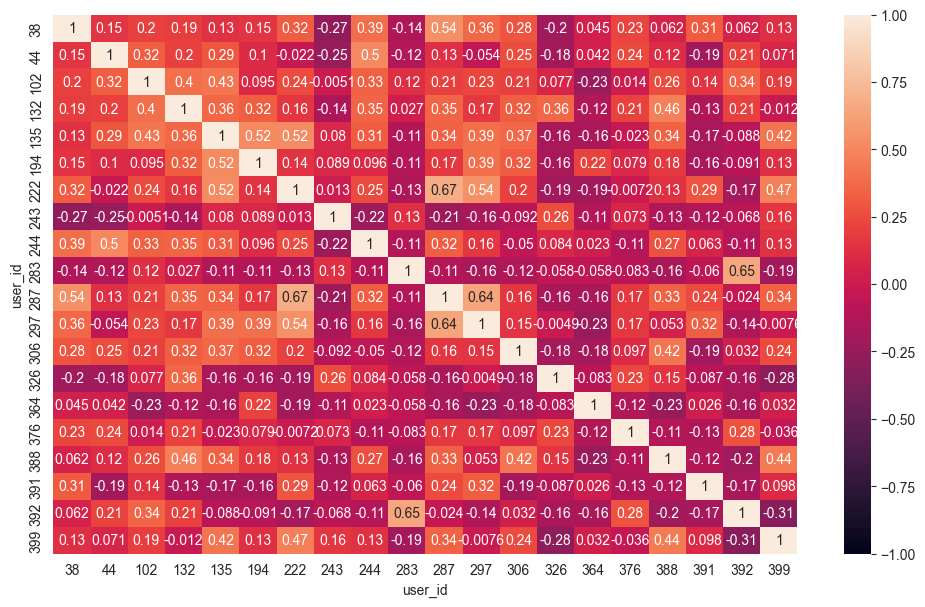

In [ ]:
plt.figure(figsize=(12, 7))
sns.heatmap(pt.corr(), annot = True, vmin = -1, vmax = 1)
plt.show()

In [ ]:
#find out the similar items
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# food item compared to all other food items (ABxBA)
similarity_scores = cosine_similarity(pt)
similarity_scores.shape
#euclidian distance of (26x26) items

(26, 26)

In [ ]:
#MAIN RECOMMENDER SYSTEM
# Recommends similar items based on a similarity matrix (pt).
#   Args:
#       ItemName: The name of the item for which to recommend similar items.
#   Returns:
#       None (prints the recommended item names).

def recommend(ItemName):
    """
    Recommends similar items based on a similarity matrix pt.
    
    Args:
        ItemName: The name of the item for which to recommend similar items.
    
    Returns:
        List of recommended items with details [ItemName, Description, ImageURL, Price]
    """
    #index fetch
    try:
        # Get index of the item
        index = np.where(pt.index == ItemName)[0][0]
        
        # Get similarity scores and sort
        similaritems = sorted(
            list(enumerate(similarity_scores[index])), 
            key=lambda xy: xy[1],
            reverse=True
        )[1:6]  # Top 5 similar items (excluding itself)
        
        data = []
        for idx, score in similaritems:
            item_name = pt.index[idx]
            temp_df = menu[menu['ItemName'] == item_name].drop_duplicates('ItemName')
            
            if len(temp_df) > 0:
                item = {
                    'ItemName': temp_df['ItemName'].values[0],
                    'Description': temp_df['Description'].values[0],
                    'ImageURL': temp_df['ImageURL'].values[0],
                    'Price': temp_df['Price'].values[0],
                    'SimilarityScore': score
                }
                data.append(item)
        
        return data
    
    except IndexError:
        print(f"Item '{ItemName}' not found in the dataset")
        return []
    except Exception as e:
        print(f"Error in recommendation: {e}")
        return []
    

In [ ]:
recommend('Pulled Pork Sliders')

[{'ItemName': 'Blueberry Lavender Lemonade',
  'Description': 'Lemonade with blueberry and lavender flavors for a unique twist.',
  'ImageURL': 'beverage_image_20.jpg',
  'Price': 336.75,
  'SimilarityScore': 0.7928412200298767},
 {'ItemName': 'Black Bean and Corn Salad',
  'Description': 'Black beans, corn, red onion, and cilantro tossed in a lime vinaigrette.',
  'ImageURL': 'lunch_image_22.jpg',
  'Price': 636.75,
  'SimilarityScore': 0.7424254676971741},
 {'ItemName': 'Apple Cinnamon Crisp',
  'Description': 'Baked apple slices with a cinnamon and oat topping, served with vanilla bean ice cream.',
  'ImageURL': 'dessert_image_26.jpg',
  'Price': 561.75,
  'SimilarityScore': 0.6690666118148464},
 {'ItemName': 'Lemon Herb Grilled Salmon',
  'Description': 'Grilled salmon fillet marinated in lemon, herbs, and garlic, served with roasted vegetables.',
  'ImageURL': 'dinner_image_21.jpg',
  'Price': 1249.25,
  'SimilarityScore': 0.604166193107172},
 {'ItemName': 'Ginger Soy Glazed Chick

In [ ]:
#returns the index position of any item in 'pivot table(pt)'
#np.where(pt.index == 'BLT Sandwich')[0][0] 

In [ ]:
#item index will also be available within distance - enumerate
#list(enumerate(similarity_scores[0]))

In [ ]:
#sorting on the basis or similarity score (most similar items will be on top)(item no 1-4 will be displayed)
#sorted(list(enumerate(similarity_scores[0])),key = lambda x:x[1],reverse = True)[1:4]
#paste this entire thing in similar items

In [ ]:
item_count = len(popular_df)  # Get the number of items


In [ ]:
import pickle
import os

# Create a directory for models if it doesn't exist
os.makedirs('models', exist_ok=True)




In [ ]:
# Save with proper file handling
def save_model(data, filename):
    try:
        with open(f'models/{filename}', 'wb') as f:
            pickle.dump(data, f)
        print(f"✓ Saved {filename}")
    except Exception as e:
        print(f"✗ Error saving {filename}: {e}")

In [ ]:
# Save all models
save_model(popular_df, 'popular.pkl')
save_model(pt, 'pt.pkl')
save_model(menu, 'menu.pkl')
save_model(similarity_scores, 'similarity_scores.pkl')

✓ Saved popular.pkl
✓ Saved pt.pkl
✓ Saved menu.pkl
✓ Saved similarity_scores.pkl


In [ ]:
popular_df.columns


Index(['ItemName', 'Description', 'Price', 'ImageURL', 'num_ratings',
       'avg_ratings'],
      dtype='object')